In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic

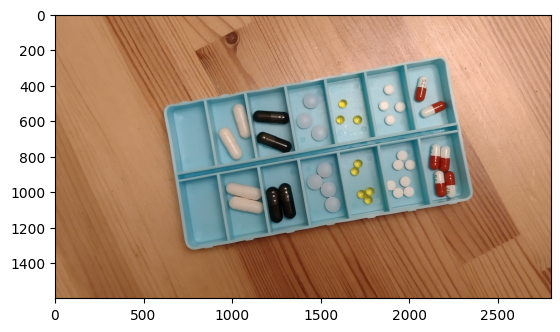

In [7]:
calib = cv2.imread('../Lab5_dane/calib.png')[..., ::-1]
plt.subplots(1, 1)[1].imshow(calib);

In [ ]:
def segment_img(img, **kwargs):
    # PARAMETRY KWARGS
    n_segments = kwargs.get('n_segments')
    sigma = kwargs.get('sigma')
    K = kwargs.get('K')
    bestLabels = kwargs.get('bestLabels')
    criteria = kwargs.get('criteria')
    attempts = kwargs.get('attempts')
    flags = kwargs.get('flags')
    # STWORZENIE SUPERPIKSELI
    segments = slic(img, n_segments = n_segments, sigma = sigma)
    unique_segments = np.unique(segments)
    segments_colors = list()
    # UTWORZENIE REPREZENTACJI SUPERPIKSELA
    for segment in unique_segments:
        segment_pixels = img[segments == segment]
        mean_color = segment_pixels.mean(axis = 0).round(0)
        segments_colors.append(mean_color)
        
    segments_colors = np.array(segments_colors)
    kmeans_colors = np.float32(np.expand_dims(segments_colors, axis = 1))
    # KMEANS
    _, labels, _ = cv2.kmeans(data = kmeans_colors, K = K, 
                              bestLabels = bestLabels, 
                              criteria = criteria,
                              attempts = attempts,
                              flags = flags)
    # SEGMENTACJA OBIEKTU
    dct = dict(zip(unique_segments, labels))
    final_img = np.vectorize(lambda x: dct.get(x, x))(segments)
    # Znajdź najczęściej występującą etykietę i uznaj ją za tło (czarne)
    unique, counts = np.unique(final_img, return_counts=True)
    background_label = unique[np.argmax(counts)]
    # Przypisz tło jako czarne, a obiekt jako biały
    binary_output = np.where(final_img == background_label, 0, 255).astype(np.uint8)

    return binary_output




def extract_object(img, mask):
    img_copy = img.copy()
    img_copy[mask == 0] = 0
    return img_copy

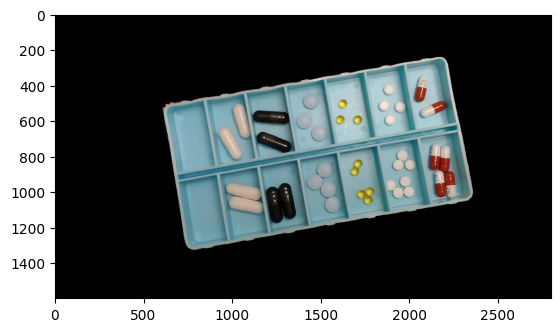

In [5]:
PARAMS = {'n_segments': 100,
        'sigma': 1,
        'K': 2,
        'bestLabels': None,
        'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
        'attempts': 20,
        'flags': cv2.KMEANS_RANDOM_CENTERS}

superpxl = segment_img(cv2.GaussianBlur(cv2.cvtColor(calib, cv2.COLOR_RGB2HLS), (21, 21), sigmaX = 0), **PARAMS)
pillbox = extract_object(calib, superpxl)
plt.imshow(pillbox)

In [6]:
np.save('pillbox.npy', pillbox)